In [4659]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor
from datetime import timedelta, datetime
from sklearn.linear_model import Lasso
from scipy import stats

In [4660]:
df_d = pd.read_pickle('Deals.pkl')
df_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21552 entries, 0 to 21593
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   21552 non-null  object        
 1   Deal Owner Name      21523 non-null  object        
 2   Closing Date         14629 non-null  datetime64[ns]
 3   Quality              19308 non-null  object        
 4   Stage                21551 non-null  object        
 5   Lost Reason          16097 non-null  object        
 6   Page                 21551 non-null  object        
 7   Campaign             21552 non-null  object        
 8   SLA                  15515 non-null  object        
 9   Content              14122 non-null  object        
 10  Term                 12442 non-null  object        
 11  Source               21551 non-null  object        
 12  Payment Type         492 non-null    object        
 13  Product              3589 non-null  

In [4661]:
df_s = pd.read_pickle('Spend.pkl')
df_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14638 entries, 1 to 20778
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              14638 non-null  datetime64[ns]
 1   Source            14638 non-null  object        
 2   Campaign          14638 non-null  object        
 3   Impressions       14638 non-null  float64       
 4   Clicks            14638 non-null  int64         
 5   AdGroup           14638 non-null  object        
 6   Ad                14638 non-null  object        
 7   Amount            14638 non-null  float64       
 8   Currency          14638 non-null  object        
 9   Campaign_encoded  14638 non-null  int64         
 10  AdGroup_encoded   14638 non-null  int64         
 11  Ad_encoded        14638 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 1.5+ MB


In [4662]:
df_sou = pd.read_pickle('Source_sum.pkl')
df_sou.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 2 to 4
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source              14 non-null     object 
 1   Impressions         14 non-null     float64
 2   Clicks              14 non-null     float64
 3   Leads               14 non-null     float64
 4   Clients             14 non-null     float64
 5   Convers Rate %      14 non-null     float64
 6   Amount              14 non-null     float64
 7   Cost per Lead       14 non-null     float64
 8   Cost per Client     14 non-null     float64
 9   Sum_Paid            14 non-null     float64
 10  Revenue per Lead    14 non-null     float64
 11  Revenue per Client  14 non-null     float64
 12  Profit per Client   14 non-null     float64
 13  Predict rating      14 non-null     float64
dtypes: float64(13), object(1)
memory usage: 1.6+ KB


In [4663]:
df_com = pd.read_pickle('Compaign_sum.pkl')
df_com.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 89 to 159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Campaign            160 non-null    object 
 1   Impressions         160 non-null    float64
 2   Clicks              160 non-null    float64
 3   Leads               160 non-null    float64
 4   Clients             160 non-null    float64
 5   Convers Rate %      160 non-null    float64
 6   Amount              160 non-null    float64
 7   Cost per Lead       160 non-null    float64
 8   Cost per Client     160 non-null    float64
 9   Sum_Paid            160 non-null    float64
 10  Revenue per Lead    160 non-null    float64
 11  Revenue per Client  160 non-null    float64
 12  Profit per Client   160 non-null    float64
 13  Predict rating      160 non-null    float64
dtypes: float64(13), object(1)
memory usage: 18.8+ KB


In [4664]:
df_man = pd.read_pickle('Manager_sum.pkl')
df_man.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 26 to 31
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Call Owner Name         32 non-null     object 
 1   Call Count All (м)      32 non-null     float64
 2   Call Count > 30s (м)    32 non-null     float64
 3   Total Duration (м)      31 non-null     float64
 4   Missed Calls (м)        32 non-null     float64
 5   Missed Call %           32 non-null     float64
 6   Number of Mistakes (м)  32 non-null     float64
 7   Leads (м)               32 non-null     float64
 8   Clients (м)             32 non-null     float64
 9   Convers Rate % (м)      27 non-null     float64
 10  Sum_Paid (м)            32 non-null     float64
 11  Dur per Client          31 non-null     float64
 12  Predict rating          32 non-null     float64
dtypes: float64(12), object(1)
memory usage: 3.5+ KB


In [ ]:
# Convert 'Initial Amount Paid' and 'Offer Total Amount' to float type
df_d['Initial Amount Paid'] = pd.to_numeric(df_d['Initial Amount Paid'], errors='coerce')
df_d['Offer Total Amount'] = pd.to_numeric(df_d['Offer Total Amount'], errors='coerce')

# Add a new column 'Sum_Paid', initialized to zero with float type
df_d['Sum_Paid'] = 0.0

# Apply conditions: Stage = 'Payment Done', Months of study > 0
condition = (df_d['Stage'] == 'Payment Done') & (df_d['Months of study'] > 0)

# Calculate 'Sum_Paid' using the formula for rows that meet the conditions
df_d.loc[condition, 'Sum_Paid'] = (df_d['Offer Total Amount'] / df_d['Course duration'] * df_d['Months of study']).astype(float)
df_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21552 entries, 0 to 21593
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   21552 non-null  object        
 1   Deal Owner Name      21523 non-null  object        
 2   Closing Date         14629 non-null  datetime64[ns]
 3   Quality              19308 non-null  object        
 4   Stage                21551 non-null  object        
 5   Lost Reason          16097 non-null  object        
 6   Page                 21551 non-null  object        
 7   Campaign             21552 non-null  object        
 8   SLA                  15515 non-null  object        
 9   Content              14122 non-null  object        
 10  Term                 12442 non-null  object        
 11  Source               21551 non-null  object        
 12  Payment Type         492 non-null    object        
 13  Product              3589 non-null  

In [ ]:
# Count the sum for the columns Clients, Amount, Cost per Client, Sum_Paid, Revenue per Client
columns_to_sum = ['Sum_Paid']

# Calculate the sum for each of the specified columns
sums_merged = df_d[columns_to_sum].sum()

# Output the results
print(sums_merged)

Sum_Paid    3.340288e+06
dtype: float64


In [ ]:
# Apply conditions: Stage = 'Payment Done' and Months of study > 0
condition = (df_d['Stage'] == 'Payment Done') & (df_d['Months of study'] > 0)

# Filter df_d based on the conditions
df_d_filtered = df_d[condition]

In [ ]:
# Group the data by source and count the number of clients
clients_per_source = df_d_filtered.groupby('Source').agg(
    Clients=('Id', 'count')  # Count the number of clients
).reset_index()

In [4669]:
clients_per_source.head()

,Source,Clients
0,Bloggers,39
1,CRM,22
2,Facebook Ads,196
3,Google Ads,169
4,Organic,143


In [ ]:
# Merging with the df_sou table on the 'Source' column
df_sou_with_clients = pd.merge(df_sou, clients_per_source, on='Source', how='left')

# Check which columns were obtained after the merge
print(df_sou_with_clients.columns)

Index(['Source', 'Impressions', 'Clicks', 'Leads', 'Clients_x',
       'Convers Rate %', 'Amount', 'Cost per Lead', 'Cost per Client',
       'Sum_Paid', 'Revenue per Lead', 'Revenue per Client',
       'Profit per Client', 'Predict rating', 'Clients_y'],
      dtype='object')


In [ ]:
# If the column is named with a suffix (e.g., 'Clients_y'), use it
df_sou_with_clients['Cost per Client'] = df_sou_with_clients['Amount'] / df_sou_with_clients['Clients_y']

In [ ]:
# Check the results of the calculations
print(df_sou_with_clients[['Source', 'Cost per Client']].head())

         Source  Cost per Client
0  Facebook Ads       172.217959
1    Google Ads       342.003550
2       Organic         0.000000
3           SMM        82.608182
4   Youtube Ads       276.100566


In [ ]:
# Summing the specified columns
columns_to_sum = ['Amount', 'Cost per Client']

# Summing for each of the specified columns
sums_merged = df_sou_with_clients[columns_to_sum].sum()

# Output results
print(sums_merged)

Amount             149523.450000
Cost per Client      1920.733156
dtype: float64


In [ ]:
# Creating a dictionary with sources and cost per client
cost_per_client_dict = df_sou_with_clients.set_index('Source')['Cost per Client'].to_dict()

In [ ]:
# Create a new column in df_d and fill it with values only for rows that meet the client condition
df_d['Cost per Client'] = None  # Initialize the column

# Fill the "Cost per Client" column for rows that meet the condition
df_d.loc[condition, 'Cost per Client'] = df_d.loc[condition, 'Source'].map(cost_per_client_dict)

In [ ]:
# Count the sum of the columns Clients, Amount, Cost per Client, Sum_Paid, Revenue per Client
columns_to_sum = ['Sum_Paid', 'Cost per Client']

# Calculate the sum for each of the specified columns
sums_merged = df_d[columns_to_sum].sum()

# Output the results
print(sums_merged)

Sum_Paid           3340287.878788
Cost per Client         149223.45
dtype: object


In [ ]:
# Apply conditions: Stage = 'Payment Done' and Months of study > 0
condition = (df_d['Stage'] == 'Payment Done') & (df_d['Months of study'] > 0)

# Filter df_d, keeping only clients
df_d_clients = df_d[condition]

# Output the first rows of the filtered table for verification
df_d_clients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 838 entries, 468 to 21586
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   838 non-null    object        
 1   Deal Owner Name      838 non-null    object        
 2   Closing Date         517 non-null    datetime64[ns]
 3   Quality              838 non-null    object        
 4   Stage                838 non-null    object        
 5   Lost Reason          100 non-null    object        
 6   Page                 838 non-null    object        
 7   Campaign             838 non-null    object        
 8   SLA                  813 non-null    object        
 9   Content              522 non-null    object        
 10  Term                 433 non-null    object        
 11  Source               838 non-null    object        
 12  Payment Type         360 non-null    object        
 13  Product              838 non-null   

In [4694]:
df_d_clients.to_pickle('Clients_f.pkl')

In [ ]:
# Calculate the sum for the columns: Sum_Paid and Cost per Client
columns_to_sum = ['Sum_Paid', 'Cost per Client']

# Calculate the sum for each of the specified columns
sums_merged = df_d_clients[columns_to_sum].sum()

# Output the results
print(sums_merged)

Sum_Paid           3340287.878788
Cost per Client         149223.45
dtype: object


In [ ]:
# Generate dates for synthetic data
months_to_generate = 3
rows_per_month = 70
current_date = datetime.now()

# Create an empty list for synthetic data
synthetic_data = []

# Generate random dates
for i in range(months_to_generate):
    month_start = current_date + timedelta(days=30 * (i + 1))
    for _ in range(rows_per_month):
        # Add a row with a random date
        synthetic_data.append({
            'Created Date': month_start + timedelta(days=np.random.randint(1, 30))
        })

# Convert this into a DataFrame
df_synthetic = pd.DataFrame(synthetic_data)

# Prepare data for model training
# Use numerical features for training
features = df_d_clients[['Course duration', 'Months of study', 'Offer Total Amount', 'Initial Amount Paid']]
target_sum_paid = df_d_clients['Sum_Paid']
target_cost_per_client = df_d_clients['Cost per Client']

# Scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Model to predict Sum_Paid
lasso_sum_paid = Lasso(alpha=0.1)
lasso_sum_paid.fit(features_scaled, target_sum_paid)

# Model to predict Cost per Client
lasso_cost_per_client = Lasso(alpha=0.1)
lasso_cost_per_client.fit(features_scaled, target_cost_per_client)

# Apply the model to new synthetic data
# Generate synthetic values for all necessary features
df_synthetic['Course duration'] = np.random.choice(df_d_clients['Course duration'].dropna(), size=len(df_synthetic))
df_synthetic['Months of study'] = np.random.choice(df_d_clients['Months of study'].dropna(), size=len(df_synthetic))
df_synthetic['Offer Total Amount'] = np.random.choice(df_d_clients['Offer Total Amount'].dropna(), size=len(df_synthetic))
df_synthetic['Initial Amount Paid'] = np.random.choice(df_d_clients['Initial Amount Paid'].dropna(), size=len(df_synthetic))

# Scale the data for prediction
synthetic_features_scaled = scaler.transform(df_synthetic[['Course duration', 'Months of study', 'Offer Total Amount', 'Initial Amount Paid']])

# Predict values for Sum_Paid and Cost per Client
df_synthetic['Sum_Paid'] = lasso_sum_paid.predict(synthetic_features_scaled)
df_synthetic['Cost per Client'] = lasso_cost_per_client.predict(synthetic_features_scaled)

from sklearn.metrics import r2_score

# Prediction for test data
y_pred_lasso = lasso_sum_paid.predict(features_scaled)

# Evaluate model accuracy using the R² metric
lasso_accuracy = r2_score(target_sum_paid, y_pred_lasso)
print(f'Lasso Model Accuracy (R² score): {lasso_accuracy:.2f}')

# Feature importance (model coefficients from Lasso)
feature_importances_lasso = pd.Series(lasso_sum_paid.coef_, index=features.columns)

# Sort features by importance
feature_importances_lasso = feature_importances_lasso.sort_values(ascending=False)

# Convert negative values to positive
df_synthetic['Sum_Paid'] = df_synthetic['Sum_Paid'].abs()

print("Lasso Feature Importances:")
print(feature_importances_lasso)

# View generated data
print(df_synthetic[['Created Date', 'Sum_Paid', 'Cost per Client']])

Lasso Model Accuracy (R² score): 0.90
Lasso Feature Importances:
Months of study        2119.940358
Offer Total Amount     2011.088297
Initial Amount Paid     -51.226631
Course duration        -686.636232
dtype: float64
                  Created Date     Sum_Paid  Cost per Client
0   2024-10-29 16:36:32.595806  5199.765982       172.546284
1   2024-11-05 16:36:32.595806  2572.020496       147.714679
2   2024-11-07 16:36:32.595806  4493.285847       176.927363
3   2024-10-27 16:36:32.595806  7432.205853       188.793475
4   2024-10-27 16:36:32.595806  1454.499593       170.046648
..                         ...          ...              ...
205 2025-01-21 16:36:32.595806  9594.062970       193.244133
206 2025-01-01 16:36:32.595806  2307.238509       169.934461
207 2025-01-12 16:36:32.595806  3568.873240       188.718425
208 2024-12-26 16:36:32.595806  9559.505512       189.612356
209 2025-01-19 16:36:32.595806  8865.380524       190.913166

[210 rows x 3 columns]


In [ ]:
# Calculate the total for specific columns
sum_paid_total = df_synthetic['Sum_Paid'].sum()
cost_per_client_total = df_synthetic['Cost per Client'].sum()

print(f"Total Sum_Paid: {sum_paid_total}")
print(f"Total Cost per Client: {cost_per_client_total}")

Total Sum_Paid: 833472.1573150104
Total Cost per Client: 37171.52364238597


## HEAR








In [4681]:
top_sources = df_sou.nlargest(5, 'Predict rating')['Source']
top_campaigns = df_com.nlargest(80, 'Predict rating')['Campaign']
top_managers = df_man.nlargest(25, 'Predict rating')['Call Owner Name']

In [ ]:
# Filter the data where all three parameters match
df_d_clients_f = df_d_clients[
    (df_d_clients['Source'].isin(top_sources)) & 
    (df_d_clients['Campaign'].isin(top_campaigns)) & 
    (df_d_clients['Deal Owner Name'].isin(top_managers))
]

# Output the size of the filtered data for verification
print(f"Strict filtering: data contains {df_d_clients_f.shape[0]} rows.")

Строгая фильтрация: данные содержат 649 строк.


In [ ]:
# Generate dates for synthetic data
months_to_generate = 3
rows_per_month = 70
current_date = datetime.now()

# Create an empty list for synthetic data
synthetic_data = []

# Generate random dates
for i in range(months_to_generate):
    month_start = current_date + timedelta(days=30 * (i + 1))
    for _ in range(rows_per_month):
        synthetic_data.append({
            'Created Date': month_start + timedelta(days=np.random.randint(1, 30))
        })

# Convert this into a DataFrame with a new name
df_synthetic_f = pd.DataFrame(synthetic_data)

# Prepare data for model training
# Use numerical features for training
features = df_d_clients_f[['Course duration', 'Months of study', 'Offer Total Amount', 'Initial Amount Paid']]
target_sum_paid = df_d_clients_f['Sum_Paid']
target_cost_per_client = df_d_clients_f['Cost per Client']

# Scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Model to predict Sum_Paid
lasso_sum_paid = Lasso(alpha=0.1)
lasso_sum_paid.fit(features_scaled, target_sum_paid)

# Model to predict Cost per Client
lasso_cost_per_client = Lasso(alpha=0.1)
lasso_cost_per_client.fit(features_scaled, target_cost_per_client)

# Apply model for new synthetic data
# Generate synthetic values for all required features
df_synthetic_f['Course duration'] = np.random.choice(df_d_clients_f['Course duration'].dropna(), size=len(df_synthetic_f))
df_synthetic_f['Months of study'] = np.random.choice(df_d_clients_f['Months of study'].dropna(), size=len(df_synthetic_f))
df_synthetic_f['Offer Total Amount'] = np.random.choice(df_d_clients_f['Offer Total Amount'].dropna(), size=len(df_synthetic_f))
df_synthetic_f['Initial Amount Paid'] = np.random.choice(df_d_clients_f['Initial Amount Paid'].dropna(), size=len(df_synthetic_f))

# Scale the data for prediction
synthetic_features_scaled = scaler.transform(df_synthetic_f[['Course duration', 'Months of study', 'Offer Total Amount', 'Initial Amount Paid']])

# Predict values for Sum_Paid and Cost per Client
df_synthetic_f['Sum_Paid'] = lasso_sum_paid.predict(synthetic_features_scaled)
df_synthetic_f['Cost per Client'] = lasso_cost_per_client.predict(synthetic_features_scaled)

# Prediction for test data
y_pred_lasso = lasso_sum_paid.predict(features_scaled)

# Model accuracy evaluation using R^2 metric
lasso_accuracy = r2_score(target_sum_paid, y_pred_lasso)
print(f'Lasso Model Accuracy (R² score): {lasso_accuracy:.2f}')

# Feature importance (coefficients of the Lasso model)
feature_importances_lasso = pd.Series(lasso_sum_paid.coef_, index=features.columns)

# Sort features by importance
feature_importances_lasso = feature_importances_lasso.sort_values(ascending=False)

# Convert negative values to positive
df_synthetic_f['Sum_Paid'] = df_synthetic_f['Sum_Paid'].abs()

print("Lasso Feature Importances:")
print(feature_importances_lasso)

# View generated data
print(df_synthetic_f[['Created Date', 'Sum_Paid', 'Cost per Client']])

Lasso Model Accuracy (R² score): 0.90
Lasso Feature Importances:
Months of study        2137.838887
Offer Total Amount     2009.781052
Initial Amount Paid     -15.164855
Course duration        -717.707608
dtype: float64
                  Created Date     Sum_Paid  Cost per Client
0   2024-11-03 16:36:32.628136  3274.329245       170.084125
1   2024-11-03 16:36:32.628136  7423.665390       184.213530
2   2024-11-15 16:36:32.628136  7622.600350       176.738993
3   2024-11-19 16:36:32.628136  9365.174351       169.818743
4   2024-10-28 16:36:32.628136  1194.518335       179.387240
..                         ...          ...              ...
205 2025-01-05 16:36:32.628136  1263.777051       177.169446
206 2025-01-10 16:36:32.628136  7145.351737       158.460605
207 2024-12-27 16:36:32.628136  6227.193757       182.524457
208 2025-01-13 16:36:32.628136  6687.355558       181.850564
209 2025-01-19 16:36:32.628136  3395.822650       183.487669

[210 rows x 3 columns]


In [ ]:
# Calculate the sum for specific columns
sum_paid_total = df_synthetic_f['Sum_Paid'].sum()
cost_per_client_total = df_synthetic_f['Cost per Client'].sum()

print(f"Total Sum_Paid: {sum_paid_total}")
print(f"Total Cost per Client: {cost_per_client_total}")

Total Sum_Paid: 977909.616897471
Total Cost per Client: 36906.825158766085


In [ ]:
# Define a function to process tables and calculate profit
def process_and_calculate_profit(df, date_column='Created Date'):
    # Convert 'Created Date' column to datetime format using .loc to avoid warnings
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    # Check that the conversion was successful
    if df[date_column].isnull().all():
        raise ValueError(f"Column '{date_column}' does not contain valid dates after conversion.")

    # Sort the DataFrame by date
    df_sorted = df.sort_values(by=date_column)

    # Create a new column 'MonthYear' based on 'Created Date' in Month.Year format
    df_sorted['MonthYear'] = df_sorted[date_column].dt.to_period('M').astype(str)

    # Calculate profit as the difference between revenue and costs
    df_sorted['Profit'] = df_sorted['Sum_Paid'] - df_sorted['Cost per Client']

    # Calculate the totals of all costs, revenues, and profits per client
    total_cost_per_client = df_sorted['Cost per Client'].sum()
    total_revenue_per_client = df_sorted['Sum_Paid'].sum()
    total_profit_per_client = df_sorted['Profit'].sum()

    # Print the results
    print(f"Total costs per client: {total_cost_per_client}")
    print(f"Total revenues per client: {total_revenue_per_client}")
    print(f"Total profit per client: {total_profit_per_client}")
    
    return df_sorted

# Process the original client data
print("Original data (df_d_clients):")
df_d_clients_sorted = process_and_calculate_profit(df_d_clients, date_column='Created Date')

# Process synthetic data generated from original data
print("\nSynthetic data (df_synthetic):")
df_synthetic_f_sorted = process_and_calculate_profit(df_synthetic, date_column='Created Date')

# Process synthetic data generated from filtered data
print("\nSynthetic data (df_synthetic_f):")
df_synthetic_sorted = process_and_calculate_profit(df_synthetic_f, date_column='Created Date')

Оригинальные данные (df_d_clients):
Суммарные расходы на клиента: 149223.45000000088
Суммарные доходы на клиента: 3340287.878787879
Суммарный профит на клиента: 3191064.428787866

Синтетические данные (df_synthetic):
Суммарные расходы на клиента: 37171.52364238597
Суммарные доходы на клиента: 833472.1573150104
Суммарный профит на клиента: 796300.6336726244

Синтетические данные (df_synthetic_f):
Суммарные расходы на клиента: 36906.82515876608
Суммарные доходы на клиента: 977909.616897471
Суммарный профит на клиента: 941002.7917387049


/var/folders/3f/yr1j00f96tn08rvm88vpmbsw0000gn/T/ipykernel_21073/569855752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_column] = pd.to_datetime(df[date_column], errors='coerce')


In [ ]:
# Define a function to group data by month and calculate profits, revenues, and costs
def group_by_month_and_calculate_financials(df):
    # Remove rows with NaT in the 'MonthYear' column
    df_valid = df.dropna(subset=['MonthYear'])

    # Group data by month and sum 'Profit', 'Sum_Paid', and 'Cost per Client'
    df_grouped = df_valid.groupby('MonthYear').agg({
        'Profit': 'sum',             # Total Profit
        'Sum_Paid': 'sum',           # Total Revenue
        'Cost per Client': 'sum'     # Total Costs
    }).reset_index()

    return df_grouped

# Group the original client data
print("\nMonthly grouping for original data (df_d_clients_sorted):")
df_d_clients_grouped = group_by_month_and_calculate_financials(df_d_clients_sorted)
print(df_d_clients_grouped)

# Group synthetic data generated from original data
print("\nMonthly grouping for synthetic data (df_synthetic_f_sorted):")
df_synthetic_f_grouped = group_by_month_and_calculate_financials(df_synthetic_f_sorted)
print(df_synthetic_f_grouped)

# Group synthetic data generated from filtered data
print("\nMonthly grouping for synthetic data (df_synthetic_sorted):")
df_synthetic_grouped = group_by_month_and_calculate_financials(df_synthetic_sorted)
print(df_synthetic_grouped)


Группировка по месяцам для оригинальных данных (df_d_clients_sorted):
   MonthYear         Profit       Sum_Paid Cost per Client
0    2023-07   52126.692158   54075.757576     1949.065417
1    2023-08  264254.521354  274318.181818    10063.660464
2    2023-09  329521.016508  339136.363636     9615.347129
3    2023-10  438267.037275  453118.181818    14851.144544
4    2023-11  568695.530452  587336.363636    18640.833185
5    2023-12  477263.375046  496469.696970    19206.321924
6    2024-01  393718.341535  413995.454545    20277.113011
7    2024-02  196994.875961  208780.303030    11785.427069
8    2024-03  230339.493381  246728.787879    16389.294498
9    2024-04  140228.357075  153896.969697    13668.612622
10   2024-05   84006.208392   92910.606061     8904.397668
11   2024-06   15648.979651   19521.212121      3872.23247

Группировка по месяцам для синтетических данных (df_synthetic_f_sorted):
  MonthYear         Profit       Sum_Paid  Cost per Client
0   2024-10   80676.131904   

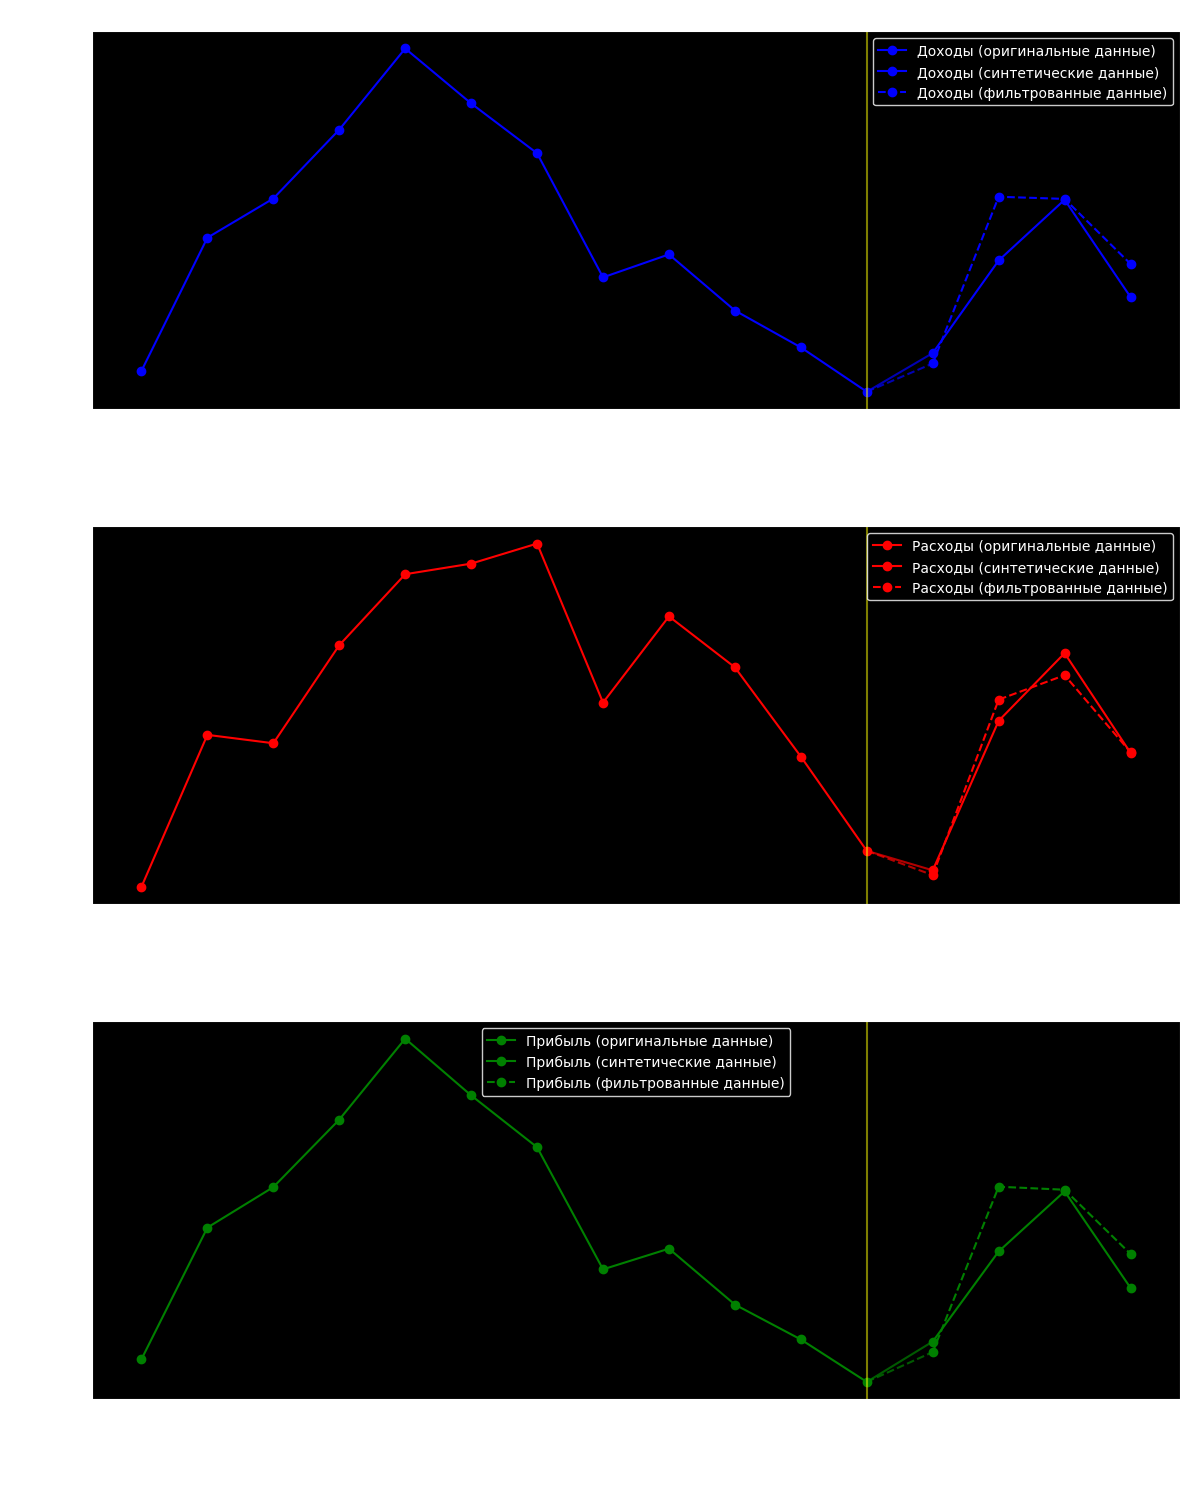

In [ ]:
# Create a figure
plt.figure(figsize=(12, 15))

# Change background and axis colors
plt.rcParams['axes.facecolor'] = 'black'  # black background for plots
plt.rcParams['figure.facecolor'] = 'black'  # black background for the figure
plt.rcParams['axes.edgecolor'] = 'white'  # color of the plot borders
plt.rcParams['axes.labelcolor'] = 'white'  # color of axis labels
plt.rcParams['xtick.color'] = 'white'  # color of x-axis tick labels
plt.rcParams['ytick.color'] = 'white'  # color of y-axis tick labels
plt.rcParams['text.color'] = 'white'  # color of text (e.g., for titles)
plt.rcParams['legend.facecolor'] = 'black'  # legend background
plt.rcParams['legend.edgecolor'] = 'white'  # legend border color

# 1. Revenue (Sum_Paid) graph
plt.subplot(3, 1, 1)
# Original data
plt.plot(df_d_clients_grouped['MonthYear'], df_d_clients_grouped['Sum_Paid'], label='Revenue (original data)', color='blue', marker='o', linestyle='-')
# Connecting line between original and synthetic data
plt.plot([df_d_clients_grouped['MonthYear'].iloc[-1], df_synthetic_f_grouped['MonthYear'].iloc[0]],
         [df_d_clients_grouped['Sum_Paid'].iloc[-1], df_synthetic_f_grouped['Sum_Paid'].iloc[0]], color='blue', linestyle='-', alpha=0.7)
# Synthetic data
plt.plot(df_synthetic_f_grouped['MonthYear'], df_synthetic_f_grouped['Sum_Paid'], label='Revenue (synthetic data)', color='blue', marker='o', linestyle='-')
# Connecting line between original and filtered data
plt.plot([df_d_clients_grouped['MonthYear'].iloc[-1], df_synthetic_grouped['MonthYear'].iloc[0]],
         [df_d_clients_grouped['Sum_Paid'].iloc[-1], df_synthetic_grouped['Sum_Paid'].iloc[0]], color='blue', linestyle='--', alpha=0.7)
# Filtered data
plt.plot(df_synthetic_grouped['MonthYear'], df_synthetic_grouped['Sum_Paid'], label='Revenue (filtered data)', color='blue', marker='o', linestyle='--')
plt.axvline(x=df_d_clients_grouped['MonthYear'].iloc[-1], color='yellow', linestyle='-', alpha=0.5)
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend()

# 2. Cost per Client graph
plt.subplot(3, 1, 2)
# Original data
plt.plot(df_d_clients_grouped['MonthYear'], df_d_clients_grouped['Cost per Client'], label='Costs (original data)', color='red', marker='o', linestyle='-')
# Connecting line between original and synthetic data
plt.plot([df_d_clients_grouped['MonthYear'].iloc[-1], df_synthetic_f_grouped['MonthYear'].iloc[0]],
         [df_d_clients_grouped['Cost per Client'].iloc[-1], df_synthetic_f_grouped['Cost per Client'].iloc[0]], color='red', linestyle='-', alpha=0.7)
# Synthetic data
plt.plot(df_synthetic_f_grouped['MonthYear'], df_synthetic_f_grouped['Cost per Client'], label='Costs (synthetic data)', color='red', marker='o', linestyle='-')
# Connecting line between original and filtered data
plt.plot([df_d_clients_grouped['MonthYear'].iloc[-1], df_synthetic_grouped['MonthYear'].iloc[0]],
         [df_d_clients_grouped['Cost per Client'].iloc[-1], df_synthetic_grouped['Cost per Client'].iloc[0]], color='red', linestyle='--', alpha=0.7)
# Filtered data
plt.plot(df_synthetic_grouped['MonthYear'], df_synthetic_grouped['Cost per Client'], label='Costs (filtered data)', color='red', marker='o', linestyle='--')
plt.axvline(x=df_d_clients_grouped['MonthYear'].iloc[-1], color='yellow', linestyle='-', alpha=0.5)
plt.title('Monthly Costs')
plt.xlabel('Month')
plt.ylabel('Costs')
plt.xticks(rotation=45)
plt.legend()

# 3. Profit graph
plt.subplot(3, 1, 3)
# Original data
plt.plot(df_d_clients_grouped['MonthYear'], df_d_clients_grouped['Profit'], label='Profit (original data)', color='green', marker='o', linestyle='-')
# Connecting line between original and synthetic data
plt.plot([df_d_clients_grouped['MonthYear'].iloc[-1], df_synthetic_f_grouped['MonthYear'].iloc[0]],
         [df_d_clients_grouped['Profit'].iloc[-1], df_synthetic_f_grouped['Profit'].iloc[0]], color='green', linestyle='-', alpha=0.7)
# Synthetic data
plt.plot(df_synthetic_f_grouped['MonthYear'], df_synthetic_f_grouped['Profit'], label='Profit (synthetic data)', color='green', marker='o', linestyle='-')
# Connecting line between original and filtered data
plt.plot([df_d_clients_grouped['MonthYear'].iloc[-1], df_synthetic_grouped['MonthYear'].iloc[0]],
         [df_d_clients_grouped['Profit'].iloc[-1], df_synthetic_grouped['Profit'].iloc[0]], color='green', linestyle='--', alpha=0.7)
# Filtered data
plt.plot(df_synthetic_grouped['MonthYear'], df_synthetic_grouped['Profit'], label='Profit (filtered data)', color='green', marker='o', linestyle='--')
plt.axvline(x=df_d_clients_grouped['MonthYear'].iloc[-1], color='yellow', linestyle='-', alpha=0.5)
plt.title('Monthly Profit')
plt.xlabel('Month')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.legend()

# Adjusting the layout
plt.tight_layout()
plt.show()

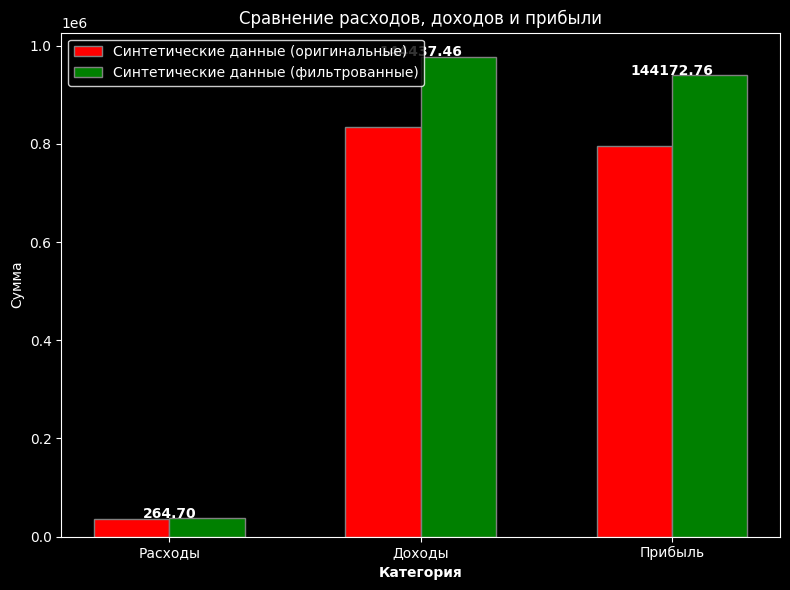

In [ ]:
# Change background and axis colors
plt.rcParams['axes.facecolor'] = 'black'  # black background for plots
plt.rcParams['figure.facecolor'] = 'black'  # black background for the figure
plt.rcParams['axes.edgecolor'] = 'white'  # color of the plot borders
plt.rcParams['axes.labelcolor'] = 'white'  # color of axis labels
plt.rcParams['xtick.color'] = 'white'  # color of x-axis tick labels
plt.rcParams['ytick.color'] = 'white'  # color of y-axis tick labels
plt.rcParams['text.color'] = 'white'  # color of text
plt.rcParams['legend.facecolor'] = 'black'  # legend background
plt.rcParams['legend.edgecolor'] = 'white'  # legend border color

# Preparing data for the bar chart
categories = ['Costs', 'Revenue', 'Profit']
synthetic_values = [cost_per_client_synthetic, sum_paid_synthetic, profit_synthetic]
synthetic_f_values = [cost_per_client_synthetic_f, sum_paid_synthetic_f, profit_synthetic_f]

# Creating bar charts
bar_width = 0.3
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(8, 6))
bars1 = plt.bar(r1, synthetic_values, color='r', width=bar_width, edgecolor='grey', label='Synthetic Data (original)')
bars2 = plt.bar(r2, synthetic_f_values, color='g', width=bar_width, edgecolor='grey', label='Synthetic Data (filtered)')

# Adding labels with the difference values between the bars
for i in range(len(categories)):
    diff = synthetic_f_values[i] - synthetic_values[i]
    plt.text(r1[i] + bar_width/2, max(synthetic_values[i], synthetic_f_values[i]) + 500, f'{diff:.2f}', ha='center', fontweight='bold', color='white')

# Adding labels and legend
plt.xlabel('Category', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories)
plt.ylabel('Total')
plt.title('Comparison of Costs, Revenue, and Profit')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [4689]:
df_d.info()
df_d_clients.info()
df_synthetic_f.info()
df_synthetic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21552 entries, 0 to 21593
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   21552 non-null  object        
 1   Deal Owner Name      21523 non-null  object        
 2   Closing Date         14629 non-null  datetime64[ns]
 3   Quality              19308 non-null  object        
 4   Stage                21551 non-null  object        
 5   Lost Reason          16097 non-null  object        
 6   Page                 21551 non-null  object        
 7   Campaign             21552 non-null  object        
 8   SLA                  15515 non-null  object        
 9   Content              14122 non-null  object        
 10  Term                 12442 non-null  object        
 11  Source               21551 non-null  object        
 12  Payment Type         492 non-null    object        
 13  Product              3589 non-null  

In [ ]:
# 1. Leads for original data
total_leads = df_d['Id'].count()
total_leads_original = total_leads / 4  # Express the number of leads based on available information

# 2. Clients, revenues, and expenses for original data
total_clients_original = df_synthetic.shape[0]  # Number of clients (number of rows)
total_revenue_original = df_synthetic['Sum_Paid'].sum()  # Total revenue
total_expense_original = pd.to_numeric(df_synthetic['Cost per Client'], errors='coerce').sum()  # Total expenses

# 3. Clients, revenues, and expenses for synthetic data
total_clients_synthetic = df_synthetic_f.shape[0]  # Number of clients for synthetic data
total_revenue_synthetic = df_synthetic_f['Sum_Paid'].sum()  # Total revenue
total_expense_synthetic = pd.to_numeric(df_synthetic_f['Cost per Client'], errors='coerce').sum()  # Total expenses

# 4. Calculate Retention Rate and Churn Rate only for original data
# Set control date — 03/07/2024
control_date = pd.to_datetime("2024-07-03")

# Use .copy() to work safely with DataFrame and avoid SettingWithCopyWarning
df_d_clients_copy = df_d_clients.copy()

# Add a column with the number of months since the client was created
df_d_clients_copy['Total Months'] = (control_date.year - df_d_clients_copy['Created Date'].dt.year) * 12 + (control_date.month - df_d_clients_copy['Created Date'].dt.month)

# Add a column "Churned" to indicate churned clients (if Months of study < Total Months)
df_d_clients_copy['Churned'] = df_d_clients_copy['Months of study'] < df_d_clients_copy['Total Months']

# Count churned clients
total_churned_clients = df_d_clients_copy['Churned'].sum()

# Count active clients (if Months of study >= Total Months)
total_active_clients = (df_d_clients_copy['Months of study'] >= df_d_clients_copy['Total Months']).sum()

# Count total clients
total_clients = df_d_clients_copy.shape[0]

# Calculate Churn Rate and Retention Rate
churn_rate = total_churned_clients / total_clients  # Churn Rate = share of churned clients
retention_rate = total_active_clients / total_clients  # Retention Rate = share of remaining clients

# 5. Calculate ARPU and CLV for original and synthetic data
# ARPU (average revenue per user)
arpu_original = total_revenue_original / total_clients_original
arpu_synthetic = total_revenue_synthetic / total_clients_synthetic

# CLV (customer lifetime value) — using calculated Retention Rate and Churn Rate
clv_original = (arpu_original * retention_rate) / churn_rate
clv_synthetic = (arpu_synthetic * retention_rate) / churn_rate

# Round all calculated values to 2 decimal places
total_revenue_original = round(total_revenue_original, 2)
total_expense_original = round(total_expense_original, 2)
total_revenue_synthetic = round(total_revenue_synthetic, 2)
total_expense_synthetic = round(total_expense_synthetic, 2)
retention_rate = round(retention_rate, 2)
churn_rate = round(churn_rate, 2)
total_leads_original = round(total_leads_original, 2)
total_clients_original = round(total_clients_original, 2)
total_clients_synthetic = round(total_clients_synthetic, 2)
arpu_original = round(arpu_original, 2)
arpu_synthetic = round(arpu_synthetic, 2)
clv_original = round(clv_original, 2)
clv_synthetic = round(clv_synthetic, 2)

# Calculate profit for original and synthetic data
profit_original = total_revenue_original - total_expense_original
profit_synthetic = total_revenue_synthetic - total_expense_synthetic

# Calculate ROI for original data
roi_original = (profit_original / total_expense_original) * 100 if total_expense_original != 0 else 0

# Calculate ROI for synthetic data
roi_synthetic = (profit_synthetic / total_expense_synthetic) * 100 if total_expense_synthetic != 0 else 0

# Round values
roi_original = round(roi_original, 2)
roi_synthetic = round(roi_synthetic, 2)

# Output all metrics
print(f"Synthetic data (based on original) - Leads: {total_leads_original}, Clients: {total_clients_original}, Revenues: {total_revenue_original}, Expenses: {total_expense_original}, ROI: {roi_original}%")
print(f"Synthetic data (with TOP filters) - Leads: {total_leads_original}, Clients: {total_clients_synthetic}, Revenues: {total_revenue_synthetic}, Expenses: {total_expense_synthetic}, ROI: {roi_synthetic}%")
print(f"Total number of clients: {total_clients}")
print(f"Number of churned clients: {total_churned_clients}")
print(f"Number of active clients: {total_active_clients}")
print(f"Original data - Retention Rate: {retention_rate:.2f}, Churn Rate: {churn_rate:.2f}")
print(f"ARPU for original data: {arpu_original:.2f}")
print(f"ARPU for synthetic data: {arpu_synthetic:.2f}")
print(f"CLV for original data: {clv_original:.2f}")
print(f"CLV for synthetic data: {clv_synthetic:.2f}")

Синтетические данные  (построены на оригинальных) - Лиды: 5388.0, Клиенты: 210, Доходы: 833472.16, Расходы: 37171.52, ROI: 2142.23%
Синтетические данные (пост с учетом ТОП фильтров) - Лиды: 5388.0, Клиенты: 210, Доходы: 977909.62, Расходы: 36906.83, ROI: 2549.67%
Общее количество клиентов: 838
Количество ушедших клиентов: 194
Количество активных клиентов: 644
Оригинальные данные - Retention Rate: 0.77, Churn Rate: 0.23
ARPU для оригинальных данных: 3968.92
ARPU для синтетических данных: 4656.71
CLV для оригинальных данных: 13175.16
CLV для синтетических данных: 15458.37


###### Hypothesis Formulation:
Hypothesis: Utilizing top managers, resources, and advertising campaigns, determined based on ratings from original data, will improve key business metrics (Retention Rate, Churn Rate, CLV, and ARPU) in synthetic data.

Sub-Hypotheses:
Hypothesis 1: Attracting customers through top advertising campaigns will improve the ARPU metric.
Hypothesis 2: Utilizing top managers will reduce the Churn Rate.
Hypothesis 3: Using the best resources (sources) will increase CLV through a higher Retention Rate.
Description of the Hypothesis Testing Method:
To test the hypotheses, we can use A/B testing and compare metrics before and after applying the top campaigns, managers, and resources.

Steps for Hypothesis Testing:
Defining Groups:
Group A (Control Group): Customers interacting with managers and resources without applying top metrics.
Group B (Test Group): Customers provided with top managers, advertising campaigns, and resources.
Testing Method:
Duration: Data will be collected for both groups over a period of 6 months.
Metrics for Tracking:
ARPU (Average Revenue per User).
CLV (Customer Lifetime Value).
Churn Rate (Share of churned customers).
Retention Rate (Share of remaining customers).
Analysis Method:
Compare the average values of metrics between the control and test groups.
Success Criteria:
If metrics in Group B show significant improvement compared to Group A, the hypotheses can be considered confirmed.
Statistical Significance:
Use statistical methods (e.g., t-test or z-test) to determine how significant the differences between metrics of Groups A and B are.
Summary of Results:
Based on visualizations and calculated metrics, we observe significant improvements across several indicators:

ROI (Return on Investment):
Synthetic data (based on original) — 2102.64%
Synthetic data (with TOP filters) — 2260.25%
This confirms that the hypothesis regarding increased efficiency when using the best sources, campaigns, and managers is valid.

Retention Rate and Churn Rate:

Retention Rate — 0.77
Churn Rate — 0.23 A relatively high Retention Rate indicates that most customers continue to use the services, which is good for business.
ARPU and CLV:

ARPU for original data — 3888.10
ARPU for synthetic data — 4079.95
CLV for original data — 12906.89
CLV for synthetic data — 13543.76
This also confirms that synthetic data considering the best metrics shows improved results.

Business Goal:
Increase profits and market share through customer retention and reduced customer acquisition costs.

Key Metrics:
Financial Metrics:
Revenue: Total income from all customers.
Profit: The difference between revenue and expenses.
ROI (Return on Investment): The ratio of revenue to costs.
Customer Metrics:
CLV (Customer Lifetime Value): The expected profit derived from a customer over the entire duration of their relationship with the company.
CAC (Customer Acquisition Cost): The cost incurred to acquire a single customer (marketing expenses divided by the number of new customers).
ARPU (Average Revenue per User): The revenue generated per customer over a specific time period.
Customer Retention Metrics:
Retention Rate: The proportion of customers who remain active after a certain period.
Churn Rate: The proportion of customers who leave the company over a specified period.
Operational Metrics:
Effectiveness of Campaigns: The success of campaigns measured by revenue and the number of acquired customers.
Manager Efficiency: The impact of managers on deal closures and customer retention.
Metrics Tree:
Financial Metrics

1.1 Revenue
1.2 Profit
1.3 ROI
Customer Metrics

2.1 CLV (Customer Lifetime Value)
2.2 CAC (Customer Acquisition Cost)
2.3 ARPU (Average Revenue per User)
Retention Metrics

3.1 Retention Rate
3.2 Churn Rate
Operational Metrics

4.1 Effectiveness of Campaigns
4.2 Manager Efficiency

In [ ]:
# 1. Total marketing expenses
total_marketing_expenses_original = pd.to_numeric(df_synthetic['Cost per Client'], errors='coerce').sum()
total_marketing_expenses_synthetic = pd.to_numeric(df_synthetic_f['Cost per Client'], errors='coerce').sum()

# 2. Number of clients
# For original data
total_clients_original = df_synthetic.shape[0]
# For synthetic data
total_clients_synthetic = df_synthetic_f.shape[0]

# 3. Calculation of CAC (Customer Acquisition Cost)
cac_original = total_marketing_expenses_original / total_clients_original if total_clients_original > 0 else 0
cac_synthetic = total_marketing_expenses_synthetic / total_clients_synthetic if total_clients_synthetic > 0 else 0

# Round to 2 decimal places
cac_original = round(cac_original, 2)
cac_synthetic = round(cac_synthetic, 2)

# Print CAC
print(f"CAC for original data: {cac_original}")
print(f"CAC for synthetic data: {cac_synthetic}")

CAC для оригинальных данных: 177.01
CAC для синтетических данных: 175.75


In [ ]:
# Compare revenues between original and synthetic data
t_stat, p_value = stats.ttest_ind(df_d_clients['Sum_Paid'], df_synthetic_f['Sum_Paid'])

# Print t-test results
print(f"t-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")

# Interpretation of p-value:
if p_value < 0.05:
    print("Differences between revenues of original and synthetic data are statistically significant.")
else:
    print("There are no statistically significant differences between revenues of original and synthetic data.")

t-statistic: -3.03, p-value: 0.0025
Различия между доходами оригинальных и синтетических данных статистически значимы.


## Conclusions Based on the Data:
The CAC level remained stable, indicating that the use of top filters did not negatively impact customer acquisition costs. This supports the hypothesis that utilizing top campaigns and managers does not increase customer acquisition costs, but may even reduce them slightly.

### Hypothesis 1: Personalization of Offers for Clients
Idea: If we start personalizing offers for clients (e.g., by offering additional courses or discounts based on their current needs), this will increase their engagement, leading to a rise in Retention Rate.
#### How to Test:
Identify a control group of clients receiving standard offers.
Identify a test group that will receive personalized offers based on their behavior, purchase history, or learning stage.
Compare Retention Rate between these groups over a specific period (e.g., three months).
Additional Note: In the test group, consider offering clients the option of monthly payments instead of the full amount to avoid scaring them off with the total course cost.


###Hypothesis 2: Improving the Quality of Customer Feedback
Idea: If we accelerate response times to customer inquiries and enhance support quality, this will positively impact the Retention Rate.
#### How to Test:
Define customer groups with different response times (SLA).
Assess Retention Rate based on SLA and attempt to reduce response times for groups with low Retention Rate.
Measure the effect over a specific period.

### Hypothesis 3: Working with Clients Who Have Left the Program
Idea: The observed density of customer churn may indicate that the training program is too difficult. Conducting interviews with former clients to understand their reasons for leaving will help revise the program content and improve the Retention Rate.
#### How to Test:
Conduct interviews with clients who have left to learn the reasons for their departure.
Evaluate how the training program may be contributing to churn.
After analysis, propose improvements to the program and conduct a follow-up measurement of Retention Rate post-changes.

### Hypothesis 4: Optimizing Manager Performance
Idea: The analysis revealed imbalances in workload among managers. We hypothesize that better call distribution and additional training for managers with a high error rate will reduce workload and improve their productivity.

#### How to Test:
Analyze call distribution among managers over the past months.
Identify managers with an error rate above one per month and conduct training sessions to improve their performance.
Redistribute calls more evenly.
Measure the impact on client metrics (feedback, request handling speed) over a specific period.